In [20]:
import os
import time
import numpy as np
import pandas as pd
import ta  # pip install ta
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GRU, LSTM, Dense, Concatenate, 
                                     TimeDistributed, Lambda, Flatten, Attention,
                                     Multiply, RepeatVector, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
# =======================================================
# Reproducibility Boilerplate
# =======================================================
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)
np.random.seed(42)

# =======================================================
# PART 1: Data Processing & Feature Engineering
# (Same as your original code)
# =======================================================

# Desired date range
start_date_str = "02/01/2018"  # DD/MM/YYYY
end_date_str   = "28/02/2025"
start_date_filter = pd.to_datetime(start_date_str, dayfirst=True)
end_date_filter   = pd.to_datetime(end_date_str, dayfirst=True)
raw_data_dir = "./data"           # Folder with raw CSV files
filtered_data_dir = "./filtered_data_attention_updated"
os.makedirs(filtered_data_dir, exist_ok=True)

In [22]:
def calculate_tema(series, window):
    ema1 = ta.trend.EMAIndicator(close=series, window=window, fillna=False).ema_indicator()
    ema2 = ta.trend.EMAIndicator(close=ema1, window=window, fillna=False).ema_indicator()
    ema3 = ta.trend.EMAIndicator(close=ema2, window=window, fillna=False).ema_indicator()
    tema = 3 * ema1 - 3 * ema2 + ema3
    return tema

def process_csv(file_path, filename):
    try:
        if filename.upper() == "SPY.CSV":
            df = pd.read_csv(file_path, parse_dates=["Date"], dayfirst=True)
        else:
            df = pd.read_csv(file_path, parse_dates=["Date"], dayfirst=False)
        df.dropna(subset=["Date"], inplace=True)
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True).dt.tz_localize(None)
        
        required_columns = ["Close", "High", "Low", "Open", "Volume"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            print(f"Warning: {filename} is missing columns: {missing_columns}")
            return None
        
        print(f"{filename} - Date Range: {df['Date'].min()} to {df['Date'].max()}")
        df_filtered = df[(df["Date"] >= start_date_filter) & (df["Date"] <= end_date_filter)].copy()
        if df_filtered.empty:
            print(f"Warning: {filename} has no data within the specified date range.")
            return None
        
        df_filtered = df_filtered[["Date", "Open", "High", "Low", "Close", "Volume"]]
        
        # Calculate Standard Technical Indicators
        for window in [14, 26, 50, 100, 200]:
            df_filtered[f"SMA_{window}"] = ta.trend.SMAIndicator(close=df_filtered["Close"], window=window, fillna=False).sma_indicator()
            df_filtered[f"EMA_{window}"] = ta.trend.EMAIndicator(close=df_filtered["Close"], window=window, fillna=False).ema_indicator()
            df_filtered[f"TEMA_{window}"] = calculate_tema(df_filtered["Close"], window)
        
        bb_indicator = ta.volatility.BollingerBands(close=df_filtered["Close"], window=20, window_dev=2, fillna=False)
        df_filtered["BB_Hband"] = bb_indicator.bollinger_hband()
        df_filtered["BB_Mband"] = bb_indicator.bollinger_mavg()
        df_filtered["BB_Lband"] = bb_indicator.bollinger_lband()
        df_filtered["RSI_14"] = ta.momentum.RSIIndicator(close=df_filtered["Close"], window=14, fillna=False).rsi()
        macd_indicator = ta.trend.MACD(close=df_filtered["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=False)
        df_filtered["MACD"] = macd_indicator.macd()
        df_filtered["MACD_Signal"] = macd_indicator.macd_signal()
        df_filtered["MACD_Hist"] = macd_indicator.macd_diff()
        df_filtered["Mean_HL"] = (df_filtered["High"] + df_filtered["Low"]) / 2.0
        
        # Extra Relative & Trend-based Indicators
        df_filtered["RMom_14"] = df_filtered["Close"] / df_filtered["Close"].shift(14)
        for window in [14, 26, 50, 100, 200]:
            df_filtered[f"MomTEMA_{window}_ofs1"] = df_filtered[f"TEMA_{window}"] / df_filtered[f"TEMA_{window}"].shift(1)
            df_filtered[f"RCTEMA_{window}"] = df_filtered["Close"] / df_filtered[f"TEMA_{window}"]
            df_filtered[f"MomEMA_{window}_ofs1"] = df_filtered[f"EMA_{window}"] / df_filtered[f"EMA_{window}"].shift(1)
        df_filtered["RTEMA_TEMA_14_50"] = df_filtered["TEMA_14"] / df_filtered["TEMA_50"]
        df_filtered["REMA_EMA_14_50"] = df_filtered["EMA_14"] / df_filtered["EMA_50"]
        df_filtered["RSMA_SMA_14_50"] = df_filtered["SMA_14"] / df_filtered["SMA_50"]
        df_filtered["RVolSMA_20"] = df_filtered["Volume"] / df_filtered["Volume"].rolling(window=20).mean()
        
        df_filtered.dropna(inplace=True)
        df_filtered["Date"] = df_filtered["Date"].dt.strftime("%Y-%m-%d")
        return df_filtered
    
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

In [23]:
# Main processing loop
for filename in os.listdir(raw_data_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(raw_data_dir, filename)
        processed_df = process_csv(file_path, filename)
        if processed_df is not None:
            output_path = os.path.join(filtered_data_dir, filename)
            processed_df.to_csv(output_path, index=False)
            print(f"Processed {filename} and saved to {output_path}")
print("Processing complete.")


AAPL.csv - Date Range: 1980-12-12 05:00:00 to 2025-03-03 05:00:00
Processed AAPL.csv and saved to ./filtered_data_attention_updated\AAPL.csv
ABBV.csv - Date Range: 2013-01-02 05:00:00 to 2025-03-03 05:00:00
Processed ABBV.csv and saved to ./filtered_data_attention_updated\ABBV.csv
ADBE.csv - Date Range: 1986-08-13 04:00:00 to 2025-03-03 05:00:00
Processed ADBE.csv and saved to ./filtered_data_attention_updated\ADBE.csv
AMD.csv - Date Range: 1980-03-17 05:00:00 to 2025-03-03 05:00:00
Processed AMD.csv and saved to ./filtered_data_attention_updated\AMD.csv
AMT.csv - Date Range: 1998-02-27 05:00:00 to 2025-03-03 05:00:00
Processed AMT.csv and saved to ./filtered_data_attention_updated\AMT.csv
AMZN.csv - Date Range: 1997-05-15 04:00:00 to 2025-03-03 05:00:00
Processed AMZN.csv and saved to ./filtered_data_attention_updated\AMZN.csv
BA.csv - Date Range: 1962-01-02 05:00:00 to 2025-03-03 05:00:00
Processed BA.csv and saved to ./filtered_data_attention_updated\BA.csv
BAC.csv - Date Range: 197

In [24]:
# Main processing loop
for filename in os.listdir(raw_data_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(raw_data_dir, filename)
        processed_df = process_csv(file_path, filename)
        if processed_df is not None:
            output_path = os.path.join(filtered_data_dir, filename)
            processed_df.to_csv(output_path, index=False)
            print(f"Processed {filename} and saved to {output_path}")
print("Processing complete.")

AAPL.csv - Date Range: 1980-12-12 05:00:00 to 2025-03-03 05:00:00
Processed AAPL.csv and saved to ./filtered_data_attention_updated\AAPL.csv
ABBV.csv - Date Range: 2013-01-02 05:00:00 to 2025-03-03 05:00:00
Processed ABBV.csv and saved to ./filtered_data_attention_updated\ABBV.csv
ADBE.csv - Date Range: 1986-08-13 04:00:00 to 2025-03-03 05:00:00
Processed ADBE.csv and saved to ./filtered_data_attention_updated\ADBE.csv
AMD.csv - Date Range: 1980-03-17 05:00:00 to 2025-03-03 05:00:00
Processed AMD.csv and saved to ./filtered_data_attention_updated\AMD.csv
AMT.csv - Date Range: 1998-02-27 05:00:00 to 2025-03-03 05:00:00
Processed AMT.csv and saved to ./filtered_data_attention_updated\AMT.csv
AMZN.csv - Date Range: 1997-05-15 04:00:00 to 2025-03-03 05:00:00
Processed AMZN.csv and saved to ./filtered_data_attention_updated\AMZN.csv
BA.csv - Date Range: 1962-01-02 05:00:00 to 2025-03-03 05:00:00
Processed BA.csv and saved to ./filtered_data_attention_updated\BA.csv
BAC.csv - Date Range: 197

In [25]:
# =======================================================
# PART 2: Load Filtered Data and Sequence Generation
# =======================================================

def load_csv(filepath):
    df = pd.read_csv(filepath)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.sort_values("Date", inplace=True)
    return df

def get_model_features(df):
    desired_features = [
        "Open", "High", "Low", "Close", "Volume",
        "RSI_14",
        "SMA_14", "SMA_26", "SMA_50", "SMA_100", "SMA_200",
        "EMA_14", "EMA_26", "EMA_50", "EMA_100", "EMA_200",
        "BB_Hband", "BB_Mband", "BB_Lband",
        "Mean_HL", "MACD", "MACD_Signal", "MACD_Hist",
        "RMom_14", "MomTEMA_14_ofs1", "MomTEMA_26_ofs1", "MomTEMA_50_ofs1", "MomTEMA_100_ofs1", "MomTEMA_200_ofs1",
        "RCTEMA_14", "RCTEMA_26", "RCTEMA_50", "RCTEMA_100", "RCTEMA_200",
        "MomEMA_14_ofs1", "MomEMA_26_ofs1", "MomEMA_50_ofs1", "MomEMA_100_ofs1", "MomEMA_200_ofs1",
        "RTEMA_TEMA_14_50", "REMA_EMA_14_50", "RSMA_SMA_14_50",
        "RVolSMA_20"
    ]
    for col in desired_features:
        if col not in df.columns:
            df[col] = 0.0
    return df[["Date"] + desired_features].copy()

def prepare_sequences(df, seq_length):
    dates = df["Date"].values
    df_features = df.drop(columns=["Date"])
    data_array = df_features.values
    X, y, seq_dates = [], [], []
    target_index = df_features.columns.get_loc("Close")
    for i in range(seq_length, len(data_array)):
        X.append(data_array[i-seq_length:i])
        y.append(data_array[i, target_index])
        seq_dates.append(dates[i])
    return np.array(X), np.array(y), np.array(seq_dates, dtype='datetime64[ns]')

# Use a sliding window of 20 time steps.
sequence_length = 20
X_list, y_list, dates_list, ticker_list = [], [], [], []
all_tickers = []

for filename in os.listdir(filtered_data_dir):
    if filename.endswith(".csv"):
        ticker = filename.split(".csv")[0]
        all_tickers.append(ticker)
        filepath = os.path.join(filtered_data_dir, filename)
        df_raw = load_csv(filepath)
        df_feat = get_model_features(df_raw)
        if len(df_feat) > sequence_length:
            X, y, seq_dates = prepare_sequences(df_feat, sequence_length)
            X_list.append(X)
            y_list.append(y)
            dates_list.append(seq_dates)
            ticker_list.extend([ticker] * len(y))

X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
dates_all = np.concatenate(dates_list, axis=0)
num_features = X_all.shape[2]

# Global scaling with RobustScaler
scaler = RobustScaler()
all_data = X_all.reshape(-1, num_features)
scaler.fit(all_data)
def scale_sequences(X, scaler):
    return np.array([scaler.transform(seq) for seq in X])
X_all_scaled = scale_sequences(X_all, scaler)

In [37]:
def walk_forward_split_dynamic(X, y, dates, vol_series, vol_bins, train_pct=0.6, test_pct=0.1):
    """
    Split sequences into folds using a baseline proportion (train_pct, test_pct) and adjust 
    the training window based on volatility.
    """
    splits = []
    sorted_idx = np.argsort(dates)
    X = X[sorted_idx]
    y = y[sorted_idx]
    dates = dates[sorted_idx]
    vol_series = vol_series[sorted_idx]
    
    total_samples = len(X)
    test_window = int(test_pct * total_samples)
    start_idx = 0

    while start_idx < total_samples:
        # Baseline training window from proportion of remaining data
        remaining = total_samples - start_idx - test_window
        if remaining <= 0:
            break
        baseline_train_window = int(train_pct * total_samples)
        
        # Adjust baseline training window based on volatility at the current fold
        # (Here we use the volatility at the sample corresponding to the baseline train window)
        if start_idx + baseline_train_window < total_samples:
            current_vol = vol_series[start_idx + baseline_train_window - 1]
        else:
            current_vol = vol_series[-1]
            
        if current_vol > vol_bins[1]:
            # High volatility: use a smaller fraction of the baseline (e.g., 50% of baseline)
            train_window = int(0.8 * baseline_train_window)
        elif current_vol < vol_bins[0]:
            # Low volatility: use a larger fraction (e.g., 120% of baseline)
            train_window = int(1.1 * baseline_train_window)
        else:
            # Medium volatility: use the baseline window
            train_window = baseline_train_window
        
        # Make sure we don't overshoot the remaining data
        if start_idx + train_window + test_window > total_samples:
            break
        
        X_train = X[start_idx : start_idx + train_window]
        y_train = y[start_idx : start_idx + train_window]
        X_test = X[start_idx + train_window : start_idx + train_window + test_window]
        y_test = y[start_idx + train_window : start_idx + train_window + test_window]
        
        splits.append((X_train, y_train, X_test, y_test))
        start_idx += test_window  # shift window forward by the test window length
    return splits


In [38]:
# =======================================================
# PART 3: Walk-Forward Split Function (Dynamic Version)
# =======================================================
splits = walk_forward_split_dynamic(X_all_scaled, y_all, dates_all, vol_series, volatility_bins)

In [39]:
# =======================================================
# PART 4: Distribution Strategy & Custom Callback
# =======================================================
strategy = tf.distribute.MirroredStrategy()
print("Number of devices:", strategy.num_replicas_in_sync)

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.train_start_time = time.time()
        print("Training started...")
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch+1} finished in {epoch_time:.2f} seconds. Loss: {logs.get('loss'):.4f}, Val Loss: {logs.get('val_loss'):.4f}")
    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time
        avg_epoch = np.mean(self.epoch_times)
        print(f"Training completed in {total_time:.2f} seconds over {len(self.epoch_times)} epochs (avg {avg_epoch:.2f} sec/epoch).")
time_callback = TimeHistory()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [40]:
# =======================================================
# PART 5: Build Modified LSTM-GRU Model with Temporal Attention
# =======================================================
def temporal_importance(sequence):
    """Learnable temporal weighting"""
    time_weights = TimeDistributed(Dense(1, activation='sigmoid'))(sequence)
    weighted_seq = Multiply()([sequence, time_weights])
    return weighted_seq

def build_model_with_attention():
    start_build = time.time()
    with strategy.scope():
        print("Building input and feature extraction layers...")
        inputs = Input(shape=(sequence_length, num_features))
        x = TimeDistributed(Dense(64, activation='selu'))(inputs)
        
        print("Building short-term branch with GRU layers and temporal weighting...")
        short_term = Lambda(lambda x: x[:, -5:, :])(x)
        short_branch = GRU(64, return_sequences=True, recurrent_dropout=0.2)(short_term)
        short_branch = GRU(32, return_sequences=True, recurrent_dropout=0.1)(short_branch)
        short_branch_weighted = temporal_importance(short_branch)
        short_context = GlobalAveragePooling1D()(short_branch_weighted)
        short_branch_rep = RepeatVector(sequence_length)(short_context)
        
        print("Building long-term branch with LSTM layers and temporal weighting...")
        long_branch = LSTM(128, return_sequences=True, recurrent_dropout=0.2)(x)
        long_branch = LSTM(64, return_sequences=True, recurrent_dropout=0.1)(long_branch)
        long_branch = LSTM(32, return_sequences=True, recurrent_dropout=0.1)(long_branch)
        long_branch_weighted = temporal_importance(long_branch)
        
        print("Applying Multi-Head Attention on the long-term branch outputs...")
        attn_out = tf.keras.layers.MultiHeadAttention(
            num_heads=4, key_dim=64, dropout=0.1, name='multi_head_attention_layer'
        )(long_branch_weighted, long_branch_weighted)
        context = GlobalAveragePooling1D()(attn_out)
        context = RepeatVector(sequence_length)(context)
        
        print("Fusing branches...")
        merged = Concatenate(axis=-1)([short_branch_rep, context, attn_out])
        merged_flat = Flatten()(merged)
        dense_out = Dense(32, activation='selu')(merged_flat)
        outputs = Dense(1)(dense_out)
        
        # Using Adam optimizer instead of Lion
        optimizer = Adam(learning_rate=5e-4)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=optimizer,
                      loss=Huber(delta=1.5),
                      metrics=['mae'])
    elapsed_build = time.time() - start_build
    print(f"Model built in {elapsed_build:.2f} seconds.")
    return model

In [41]:
# =======================================================
# PART 6: Walk-Forward Validation with the Modified Model (with ETA/Progress Status)
# =======================================================
fold_losses = []
total_folds = len(splits)
start_time = time.time()

# Using basic callbacks without SWA
basic_callbacks = [
    LearningRateScheduler(lambda epoch: 5e-4 * 0.95**epoch),
    TerminateOnNaN(),
    EarlyStopping(monitor='val_mae', patience=15, mode='min', restore_best_weights=True)
]

print(f"Running walk-forward validation over {total_folds} fold(s)...")
for fold_index, (X_train_fold, y_train_fold, X_test_fold, y_test_fold) in enumerate(splits, start=1):
    current_time = time.time()
    elapsed = current_time - start_time
    eta = (elapsed / fold_index) * (total_folds - fold_index)
    print(f"Processing fold {fold_index}/{total_folds}... Elapsed: {elapsed:.1f}s, ETA: {eta:.1f}s")
    
    model = build_model_with_attention()
    model.fit(X_train_fold, y_train_fold,
              epochs=20, batch_size=16,
              validation_data=(X_test_fold, y_test_fold),
              callbacks=basic_callbacks,
              verbose=1)
    loss, mae = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    print(f"Fold {fold_index}: Loss = {loss:.4f}, MAE = {mae:.4f}")
    fold_losses.append(loss)

mean_loss = np.mean(fold_losses)
print(f"Mean Loss over all folds: {mean_loss:.4f}")

Running walk-forward validation over 5 fold(s)...
Processing fold 1/5... Elapsed: 0.0s, ETA: 0.0s
Building input and feature extraction layers...
Building short-term branch with GRU layers and temporal weighting...
Building long-term branch with LSTM layers and temporal weighting...
Applying Multi-Head Attention on the long-term branch outputs...
Fusing branches...
Model built in 0.16 seconds.
Epoch 1/20
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 87s 50ms/step - loss: 45.0413 - mae: 30.7506 - val_loss: 8.2069 - val_mae: 6.1485 - learning_rate: 5.0000e-04
Epoch 2/20
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 84s 52ms/step - loss: 7.7884 - mae: 5.8846 - val_loss: 8.2291 - val_mae: 6.1997 - learning_rate: 4.7500e-04
Epoch 3/20
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - loss: 6.9086 - mae: 5.2923 - val_loss: 6.8730 - val_mae: 5.2591 - learning_rate: 4.5125e-04
Epoch 4/20
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 92s 57ms/step - loss: 6.0081 - mae: 4.6835 - val_loss: 4.8015 - val_mae: 3.8764 - learning_rate: 4.2869e-04
E

In [42]:
# =======================================================
# PART 7: Final Training on a Time-Ordered Train-Test Split
# =======================================================
sorted_idx = np.argsort(dates_all)
X_all_sorted = X_all_scaled[sorted_idx]
y_all_sorted = y_all[sorted_idx]
N = X_all_sorted.shape[0]
train_end = int(0.8 * N)
X_train_final = X_all_sorted[:train_end]
y_train_final = y_all_sorted[:train_end]
X_test_final  = X_all_sorted[train_end:]
y_test_final  = y_all_sorted[train_end:]

final_model = build_model_with_attention()
final_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = final_model.fit(
    X_train_final, y_train_final,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[final_early_stop, time_callback],
    verbose=1
)

loss, mae = final_model.evaluate(X_test_final, y_test_final)
print("Final Test Loss:", loss)
print("Final Test MAE:", mae)

Building input and feature extraction layers...
Building short-term branch with GRU layers and temporal weighting...
Building long-term branch with LSTM layers and temporal weighting...
Applying Multi-Head Attention on the long-term branch outputs...
Fusing branches...
Model built in 0.23 seconds.
Training started...
Epoch 1/100
Epoch 1 finished in 77.70 seconds. Loss: 21.1606, Val Loss: 7.6544m 40ms/step - loss: 50.2210 - mae: 34.2056   
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 78s 45ms/step - loss: 50.1837 - mae: 34.1808 - val_loss: 7.6544 - val_mae: 5.7833
Epoch 2/100
Epoch 2 finished in 64.44 seconds. Loss: 8.0187, Val Loss: 9.50200m 38ms/step - loss: 8.5919 - mae: 6.4246 
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - loss: 8.5912 - mae: 6.4241 - val_loss: 9.5020 - val_mae: 7.0444
Epoch 3/100
Epoch 3 finished in 62.44 seconds. Loss: 7.0391, Val Loss: 8.78940m 36ms/step - loss: 7.1606 - mae: 5.4647 
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - loss: 7.1606 - mae: 5.4647 - val_loss: 8.7894 

In [43]:
# PART 8: Additional Evaluation & Attention Visualization
# =======================================================
def economic_metrics(y_true, y_pred, returns):
    """Calculate trading performance metrics"""
    signals = np.sign(y_pred[1:] - y_true[:-1])
    strategy_returns = signals * returns
    sharpe = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())
    max_drawdown = (strategy_returns.cumsum() - strategy_returns.cumsum().cummax()).min()
    return sharpe, max_drawdown

def plot_attention_heatmap(attention_weights, dates):
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        attention_weights,
        xticklabels=dates,
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'}
    )
    plt.title("Temporal Attention Patterns")
    plt.xlabel("Time Steps")
    plt.ylabel("Attention Heads")
    plt.show()

# Example usage for visualization:
# attention_model = Model(inputs=final_model.input, outputs=final_model.get_layer('multi_head_attention_layer').output)
# weights = attention_model.predict(X_sample)
# plot_attention_heatmap(weights[0], dates_sample)

# 


In [44]:
# PART 9: Statistical Validation & Ethical Considerations
# =======================================================
# Commented out residual_analysis as it uses Statsmodels
# def residual_analysis(residuals):
#     # Implement your own residual analysis if needed.
#     return None

# =======================================================
# Save the final trained model
# =======================================================
final_model.save("trained_model_lstmgru_attention_new.keras")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: C:\Users\Ronak\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step
Test MAE: 9.2355
Test MSE: 884.5835
Test R² Score: 0.9811
Test Maximum Error: 234.3984
Test MAPE: 2.59%


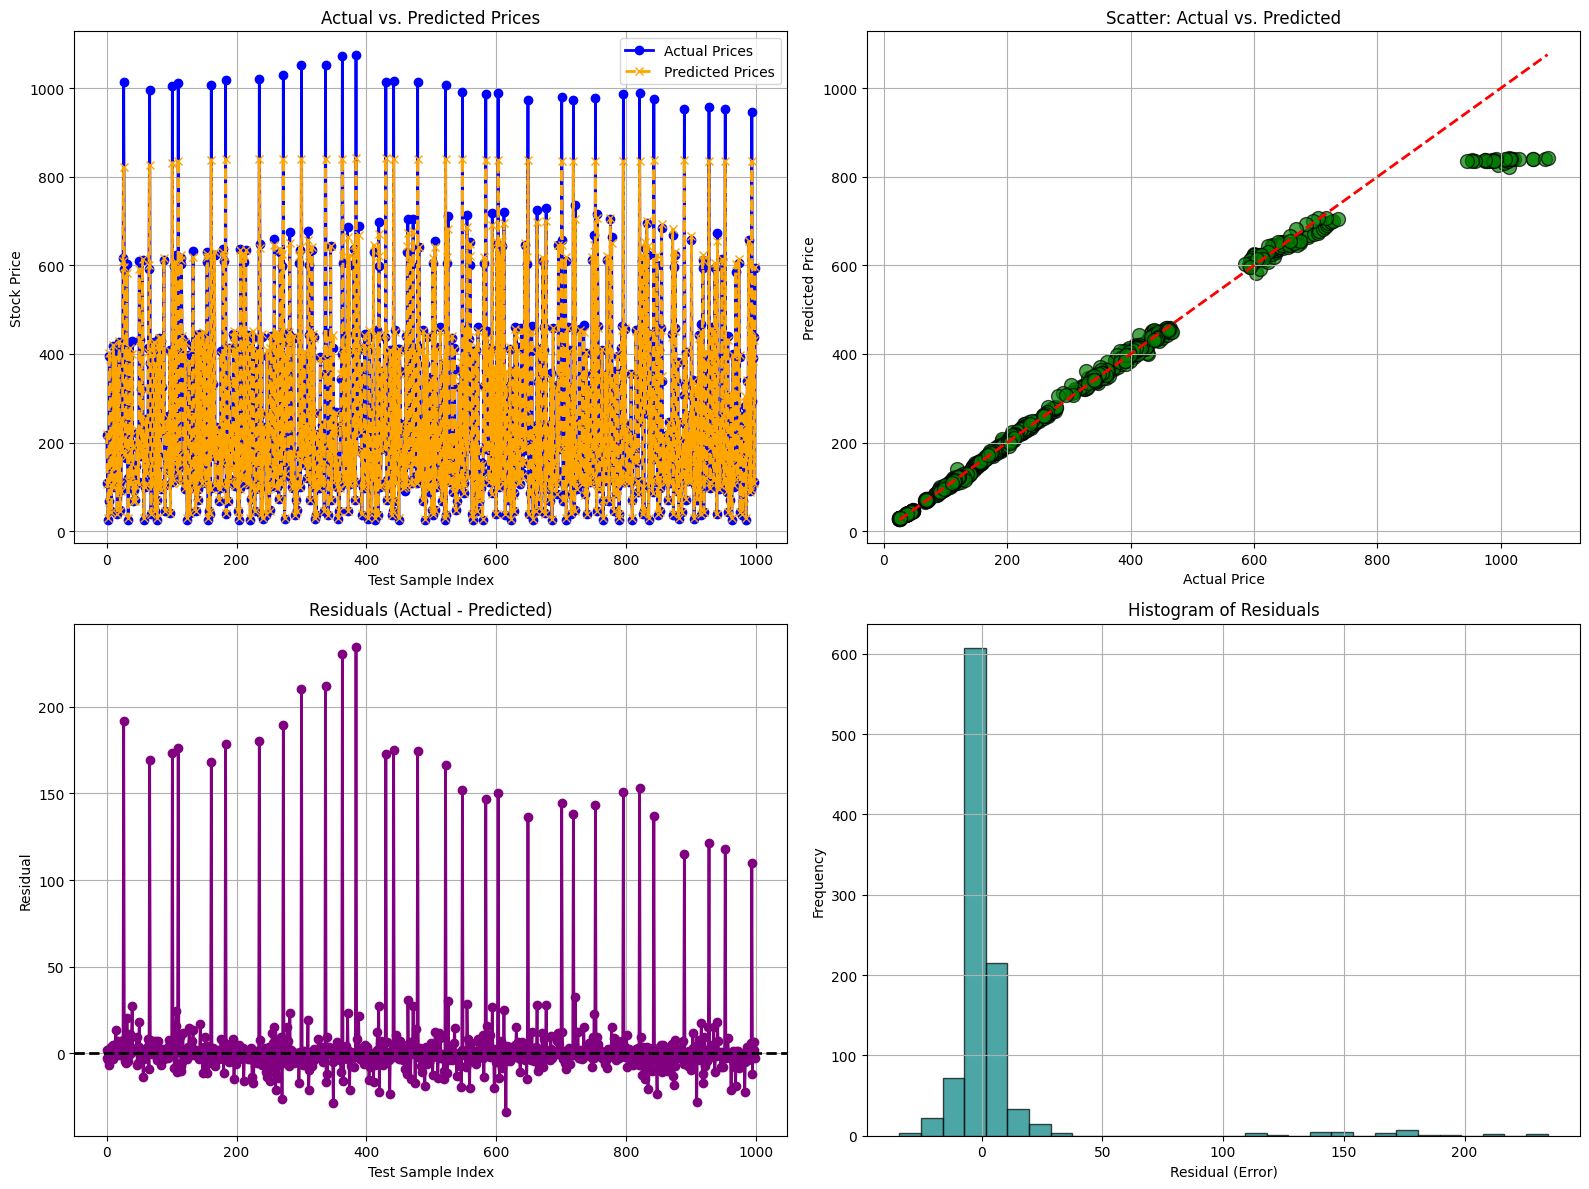

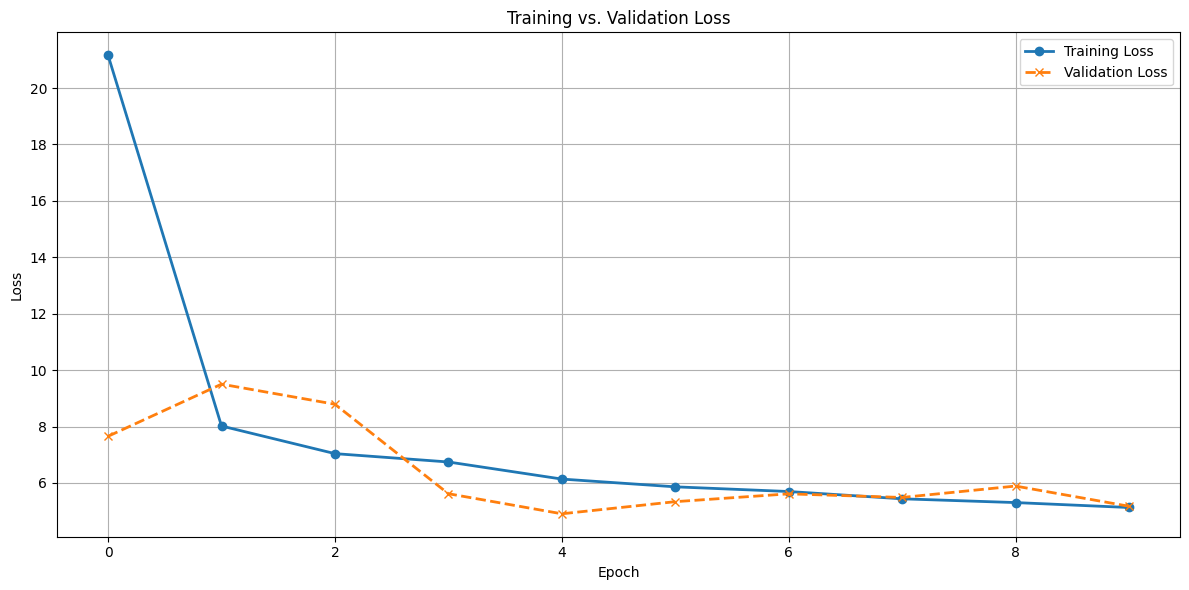

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
import numpy as np

# Ensure we have at least 1000 rows
if len(y_all_sorted) >= 1000:
    X_test = X_all_sorted[-1000:]
    y_test = y_all_sorted[-1000:]
else:
    X_test = X_all_sorted
    y_test = y_all_sorted

# Generate predictions using the final model
y_pred = final_model.predict(X_test).flatten()

# Compute Testing Metrics
mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)
max_err_value = max_error(y_test, y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

mape_value = mean_absolute_percentage_error(y_test, y_pred)

print(f"Test MAE: {mae_value:.4f}")
print(f"Test MSE: {mse_value:.4f}")
print(f"Test R² Score: {r2_value:.4f}")
print(f"Test Maximum Error: {max_err_value:.4f}")
print(f"Test MAPE: {mape_value:.2f}%")


# --- 3. Create Combined Visualizations ---
# (Not using seaborn styles; using default matplotlib style)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 3.1 Line Plot: Actual vs. Predicted Prices
axs[0, 0].plot(y_test, label="Actual Prices", color="blue", marker="o", linestyle="-", linewidth=2)
axs[0, 0].plot(y_pred, label="Predicted Prices", color="orange", marker="x", linestyle="--", linewidth=2)
axs[0, 0].set_title("Actual vs. Predicted Prices")
axs[0, 0].set_xlabel("Test Sample Index")
axs[0, 0].set_ylabel("Stock Price")
axs[0, 0].legend()
axs[0, 0].grid(True)

# 3.2 Scatter Plot: Actual vs. Predicted Prices
axs[0, 1].scatter(y_test, y_pred, color="green", alpha=0.7, edgecolor="black", s=100)
axs[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--", linewidth=2)
axs[0, 1].set_title("Scatter: Actual vs. Predicted")
axs[0, 1].set_xlabel("Actual Price")
axs[0, 1].set_ylabel("Predicted Price")
axs[0, 1].grid(True)

# 3.3 Residual Plot (Errors: Actual - Predicted)
residuals = y_test - y_pred
axs[1, 0].plot(residuals, color="purple", marker="o", linestyle="-", linewidth=2)
axs[1, 0].axhline(0, color="black", linestyle="--", linewidth=2)
axs[1, 0].set_title("Residuals (Actual - Predicted)")
axs[1, 0].set_xlabel("Test Sample Index")
axs[1, 0].set_ylabel("Residual")
axs[1, 0].grid(True)

# 3.4 Histogram of Residuals
axs[1, 1].hist(residuals, bins=30, color="teal", edgecolor="black", alpha=0.7)
axs[1, 1].set_title("Histogram of Residuals")
axs[1, 1].set_xlabel("Residual (Error)")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# --- 4. Optional: Training vs. Validation Loss Plot ---
# (Requires that you have a 'history' object returned from model.fit())
if "history" in globals():
    plt.figure(figsize=(12, 6))
    plt.plot(history.history["loss"], label="Training Loss", marker="o", linestyle="-", linewidth=2)
    plt.plot(history.history["val_loss"], label="Validation Loss", marker="x", linestyle="--", linewidth=2)
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [46]:
import math
# -------------------------------
# 1. Overall Regression Metrics
# -------------------------------
mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
rmse_value = math.sqrt(mse_value)
r2_value = r2_score(y_test, y_pred)
medae_value = median_absolute_error(y_test, y_pred)
max_err_value = max_error(y_test, y_pred)

def mape(y_true, y_pred):
    # Replace zeros in y_true to avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

mape_value = mape(y_test, y_pred)
smape_value = smape(y_test, y_pred)

print("Overall Regression Metrics:")
print(f"  MAE:    {mae_value:.4f}")
print(f"  MSE:    {mse_value:.4f}")
print(f"  RMSE:   {rmse_value:.4f}")
print(f"  R²:     {r2_value:.4f}")
print(f"  Median AE: {medae_value:.4f}")
print(f"  Max Error: {max_err_value:.4f}")
print(f"  MAPE:   {mape_value:.2f}%")
print(f"  sMAPE:  {smape_value:.2f}%")

# -------------------------------------
# 2. Financial and Directional Metrics
# -------------------------------------
def directional_accuracy(y_true, y_pred):
    # Compare the sign of the change between consecutive values.
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    correct = np.sum(np.sign(true_diff) == np.sign(pred_diff))
    return correct / len(true_diff) * 100

dir_acc = directional_accuracy(y_test, y_pred)
print(f"\nDirectional Accuracy: {dir_acc:.2f}%")

def compute_returns(prices):
    return np.diff(prices) / prices[:-1]

# Compute daily returns from actual and predicted prices.
returns_actual = compute_returns(y_test)
returns_pred = compute_returns(y_pred)

def sharpe_ratio(returns, risk_free_rate=0):
    # Sharpe Ratio: (mean excess return)/(std. deviation of return)
    return np.mean(returns - risk_free_rate) / np.std(returns)

sharpe_actual = sharpe_ratio(returns_actual)
sharpe_pred = sharpe_ratio(returns_pred)
print(f"Actual Sharpe Ratio:    {sharpe_actual:.4f}")
print(f"Predicted Sharpe Ratio: {sharpe_pred:.4f}")

def max_drawdown(prices):
    prices = np.array(prices)
    cumulative_max = np.maximum.accumulate(prices)
    drawdowns = (prices - cumulative_max) / cumulative_max
    return np.min(drawdowns) * 100  # expressed as a percentage

max_dd_actual = max_drawdown(y_test)
max_dd_pred = max_drawdown(y_pred)
print(f"Actual Maximum Drawdown:    {max_dd_actual:.2f}%")
print(f"Predicted Maximum Drawdown: {max_dd_pred:.2f}%")

# -----------------------------
# 3. Segmented Evaluation
# -----------------------------
n = len(y_test)
mid = n // 2
# Temporal Segmentation: First vs. Second Half
y_test_first, y_pred_first = y_test[:mid], y_pred[:mid]
y_test_second, y_pred_second = y_test[mid:], y_pred[mid:]

print("\nTemporal Segmentation Metrics:")
print("  First Half:")
print(f"    MAE:  {mean_absolute_error(y_test_first, y_pred_first):.4f}")
print(f"    MAPE: {mape(y_test_first, y_pred_first):.2f}%")
print("  Second Half:")
print(f"    MAE:  {mean_absolute_error(y_test_second, y_pred_second):.4f}")
print(f"    MAPE: {mape(y_test_second, y_pred_second):.2f}%")

# Volatility-based Segmentation:
# Compute absolute returns as a proxy for volatility.
returns_full = np.abs(np.diff(y_test) / y_test[:-1])
vol_threshold = np.median(returns_full)  # median as threshold

# Adjust indices (returns array is one element shorter)
high_vol_indices = np.where(np.abs(returns_full) >= vol_threshold)[0] + 1
low_vol_indices  = np.where(np.abs(returns_full) < vol_threshold)[0] + 1

if high_vol_indices.size > 0:
    print("\nHigh Volatility Days Metrics:")
    print(f"  MAE:  {mean_absolute_error(y_test[high_vol_indices], y_pred[high_vol_indices]):.4f}")
    print(f"  MAPE: {mape(y_test[high_vol_indices], y_pred[high_vol_indices]):.2f}%")
if low_vol_indices.size > 0:
    print("\nLow Volatility Days Metrics:")
    print(f"  MAE:  {mean_absolute_error(y_test[low_vol_indices], y_pred[low_vol_indices]):.4f}")
    print(f"  MAPE: {mape(y_test[low_vol_indices], y_pred[low_vol_indices]):.2f}%")

# Directional Segmentation:
# Evaluate metrics separately for days when price went up vs. down.
true_diff = np.diff(y_test)
up_indices   = np.where(true_diff > 0)[0] + 1
down_indices = np.where(true_diff < 0)[0] + 1

if up_indices.size > 0:
    print("\nUpward Movement Days Metrics:")
    print(f"  MAE:  {mean_absolute_error(y_test[up_indices], y_pred[up_indices]):.4f}")
    print(f"  MAPE: {mape(y_test[up_indices], y_pred[up_indices]):.2f}%")
if down_indices.size > 0:
    print("\nDownward Movement Days Metrics:")
    print(f"  MAE:  {mean_absolute_error(y_test[down_indices], y_pred[down_indices]):.4f}")
    print(f"  MAPE: {mape(y_test[down_indices], y_pred[down_indices]):.2f}%")

NameError: name 'median_absolute_error' is not defined